In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim
import torchvision.transforms.functional as TF
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import scikitplot as skplt
import os
from torch.nn.utils import clip_grad_norm_

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# def split_set(dataset, val_ratio=0.2):
#     valsize = int(val_ratio*(len(dataset)))
#     remsize = int(len(dataset) - valsize)
#     rem_set, val_set = torch.utils.data.random_split(dataset, [remsize, valsize])
#     return rem_set, val_set

In [4]:
# # Paths for the new dataset
# # data_path = "/content/NUAcrop_TESTINGPURPOSE.zip"  # Verify this path is correct
# extract_path = "D:\\NIT INTERNSHIP\\LCC_FASD\\training"# Use a single '/' for the beginning of the path
# validation_path = ""D:\\NIT INTERNSHIP\\LCC_FASD\\development""

# # Check if the zip file exists and is a valid zip file
# # if not os.path.exists(data_path):
# #     raise FileNotFoundError(f"The file {data_path} does not exist.")
# # if not zipfile.is_zipfile(data_path):
# #     raise ValueError(f"The file {data_path} is not a valid zip file.")

# # Extract the zip file
# # with zipfile.ZipFile(data_path, 'r') as zip_ref:
# #     zip_ref.extractall(extract_path)
# # Define transformations for the dataset
# transform = transforms.Compose([
#     transforms.Resize((224, 224)),  # Resize images to 224x224
#     transforms.ToTensor(),          # Convert images to PyTorch tensors
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with mean and std dev for pre-trained models
# ])

# # Load the dataset from the extracted directory
# # dataset = datasets.ImageFolder(root=extract_path, transform=transform)  # Use the extracted directory
# trainset, valset = (dataset, val_ratio=0.10)
# train_loader = DataLoader(trainset, batch_size=2, shuffle=True)
# val_loader = DataLoader(valset = validation_path, batch_size=2, shuffle=False)

# # Example to check the dataset
# data_iter = iter(train_loader)
# images, labels = next(data_iter)
# print(images.shape)  # Should print (batch_size, 3, H, W)






# Paths for the new dataset
train_path = "D:\\NIT INTERNSHIP\\LCC_FASD\\training"  # Path for the training data
validation_path = "D:\\NIT INTERNSHIP\\LCC_FASD\\development"  # Path for the validation data

# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with mean and std dev for pre-trained models
])

# Load the training dataset from the specified directory
train_dataset = datasets.ImageFolder(root=train_path, transform=transform)

# Load the validation dataset from the specified directory
val_dataset = datasets.ImageFolder(root=validation_path, transform=transform)

# Create DataLoader instances for training and validation datasets
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False)

# Example to check the dataset
data_iter = iter(train_loader)
images, labels = next(data_iter)
print(images.shape)  # Should print (batch_size, 3, 224, 224)

torch.Size([2, 3, 224, 224])


In [5]:
class PatchEmbedding(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim):
        super(PatchEmbedding, self).__init__()
        self.patch_size = patch_size
        self.num_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_channels, embed_dim, kernel_size=patch_size, stride=patch_size)

    def forward(self, x):
        x = x.float()
        x = self.proj(x)  # (B, embed_dim, H/patch_size, W/patch_size)
        x = x.flatten(2)  # (B, embed_dim, num_patches)
        x = x.transpose(1, 2)  # (B, num_patches, embed_dim)
        return x

In [6]:
class TransformerEncoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x2 = self.norm1(x)
        x = x + self.dropout(self.self_attn(x2, x2, x2)[0])
        x2 = self.norm2(x)
        x = x + self.dropout(self.mlp(x2))
        return x

In [7]:
class VisionTransformer(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_layers, num_heads):
        super(VisionTransformer, self).__init__()
        self.patch_embedding = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        self.pos_embedding = nn.Parameter(torch.zeros(1, (img_size // patch_size) ** 2, embed_dim))
        self.encoder_layers = nn.ModuleList([TransformerEncoderLayer(embed_dim, num_heads) for _ in range(num_layers)])
        self.layer_norm = nn.LayerNorm(embed_dim)

    def forward(self, x):
        x = x.float().to(device)
        B = x.size(0)
        x = self.patch_embedding(x)
        x = x + self.pos_embedding

        for layer in self.encoder_layers:
            x = layer(x)

        x = self.layer_norm(x)
        # print(f"VisionTransformer output shape: {x.shape}")  # Debugging statement
        return x  # Returning the full sequence



In [8]:
class TransformerDecoderLayer(nn.Module):
    def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, dropout=0.1):
        super(TransformerDecoderLayer, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.cross_attn = nn.MultiheadAttention(embed_dim, num_heads, dropout=dropout)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim)
        )
        self.norm1 = nn.LayerNorm(embed_dim)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.norm3 = nn.LayerNorm(embed_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, tgt, memory):
        tgt2 = self.norm1(tgt)
        tgt = tgt + self.dropout(self.self_attn(tgt2, tgt2, tgt2)[0])
        tgt2 = self.norm2(tgt)
        tgt = tgt + self.dropout(self.cross_attn(tgt2, memory, memory)[0])
        tgt2 = self.norm3(tgt)
        tgt = tgt + self.dropout(self.mlp(tgt2))
        return tgt

In [9]:
class CrossLayerRelationAttention(nn.Module):
    def __init__(self, embed_dim):
        super(CrossLayerRelationAttention, self).__init__()
        self.transform = nn.Sequential(
            nn.Conv2d(embed_dim, embed_dim, kernel_size=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(inplace=True)
        )
        self.embedding_func_global = nn.Sequential(
            nn.Conv2d(embed_dim, embed_dim, kernel_size=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(inplace=True)
        )
        self.embedding_func_local = nn.Sequential(
            nn.Conv2d(embed_dim * 2, embed_dim, kernel_size=1),
            nn.BatchNorm2d(embed_dim),
            nn.ReLU(inplace=True)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, z1, z2):
        B, L, C = z1.shape

        # Adjust z1 and z2 dimensions for convolution
        z1 = z1.permute(0, 2, 1).unsqueeze(3)  # Shape (B, C, L, 1)
        z2 = z2.permute(0, 2, 1).unsqueeze(3)  # Shape (B, C, L, 1)

        phi_z1 = self.transform(z1)
        phi_z2 = self.transform(z2)

        # Reshape for pairwise relation calculation
        phi_z1_flat = phi_z1.view(B, C, L)
        phi_z2_flat = phi_z2.view(B, C, L)

        pairwise_relation = torch.matmul(phi_z1_flat.transpose(1, 2), phi_z2_flat)

        R = torch.cat([pairwise_relation, pairwise_relation.transpose(1, 2)], dim=-1)

        # Reshape R to (B, C, L, 2L) for convolution
        R = R.view(B, 1, L, 2 * L).expand(B, C, L, 2 * L)

        global_relation = self.embedding_func_global(R)

        # Combine z1 and z2 for local importance calculation
        z_combined = torch.cat((z1, z2), dim=1)  # Shape (B, 2C, L, 1)
        local_importance = self.embedding_func_local(z_combined)

        importance_score = self.sigmoid(global_relation + local_importance)

        weighted_patches = importance_score * (z1 + z2)

        # Ensure weighted_patches has the correct size
        weighted_patches = weighted_patches.view(B, C, L, -1).mean(dim=-1)

        return weighted_patches.permute(0, 2, 1)  # Reshape to (B, L, C)

In [10]:
def Polarization(img):
    img = transforms.functional.to_pil_image(img, mode=None)
    # Apply transformations
    img = TF.to_grayscale(img, num_output_channels=3)  # Convert to grayscale with 3 channels
    img = TF.adjust_contrast(img, 2.0)  # Increase contrast
    img = TF.adjust_brightness(img, 1.2)  # Increase brightness
    img = transforms.functional.pil_to_tensor(img)

    return img

def batch_polarization(batch_img):
    batch = torch.stack([Polarization(img) for img in batch_img], dim=0)
    return batch

In [11]:
def Polarization(img):
    img = transforms.functional.to_pil_image(img, mode=None)
    # Apply transformations
    img = TF.to_grayscale(img, num_output_channels=3)  # Convert to grayscale with 3 channels
    img = TF.adjust_contrast(img, 2.0)  # Increase contrast
    img = TF.adjust_brightness(img, 1.2)  # Increase brightness
    img = transforms.functional.pil_to_tensor(img)
    return img

def batch_polarization(batch_img):
    batch = torch.stack([Polarization(img) for img in batch_img], dim=0)
    return batch

def show_images(images, nrow=5, ncol=5):
    fig, axes = plt.subplots(nrow, ncol, figsize=(15, 15))
    for i, ax in enumerate(axes.flatten()):
        if i < len(images):
            img = images[i].permute(1, 2, 0).numpy()  # Convert to HWC format for plotting
            ax.imshow(img)
            ax.axis('off')
    plt.show()

In [12]:
class CDCLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, padding=1):
        super(CDCLayer, self).__init__()
        self.conv = nn.Conv2d(in_channels * 2, out_channels, kernel_size, padding=padding)

    def forward(self, x):
        # print(x.shape)  # Debugging statement
        # Compute central differences in both x and y directions
        x_padded = F.pad(x, (1, 1, 1, 1), mode='replicate')
        # print(x_padded.shape)  # Debugging statement
        central_diff_x = x_padded[:, :, 1:-1, :-2] - x_padded[:, :, 1:-1, 2:]
        central_diff_y = x_padded[:, :, :-2, 1:-1] - x_padded[:, :, 2:, 1:-1]

        # Combine the central differences
        # print(central_diff_x.shape, central_diff_y.shape)  # Debugging statement
        central_diff = torch.cat((central_diff_x, central_diff_y), dim=1)
        central_diff = central_diff.float().to(device)
        # print(central_diff)

        # Apply convolution
        out = self.conv(central_diff)
        return out


In [13]:
class FaceAntiSpoofingModel(nn.Module):
    def __init__(self, img_size, patch_size, in_channels, embed_dim, num_layers, num_heads):
        super(FaceAntiSpoofingModel, self).__init__()
        self.patch_size = patch_size
        self.vit = VisionTransformer(img_size, patch_size, in_channels, embed_dim, num_layers, num_heads)
        self.encoder_layer = TransformerEncoderLayer(embed_dim, num_heads)
        self.cra = CrossLayerRelationAttention(embed_dim)

        self.CDCBlock = nn.Sequential(
            CDCLayer(in_channels=3, out_channels=16, kernel_size=3, padding=1),
            nn.ReLU(inplace=False),
            nn.AvgPool2d(2, stride=2),

            CDCLayer(in_channels=16, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=False),
            # nn.Dropout(0.2),
            nn.MaxPool2d(2, stride=2),

            CDCLayer(in_channels=32, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(2, stride=2),

            CDCLayer(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=False),
            nn.MaxPool2d(2, stride=2),
        )

        # self.CNNBlock = nn.Sequential(
        #     nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, padding=1),
        #     nn.ReLU(inplace=False),
        #     nn.AvgPool2d(2, stride=1),

        #     nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(32),
        #     nn.ReLU(inplace=False),
        #     # nn.Dropout(0.2),
        #     nn.MaxPool2d(2, stride=1),

        #     nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(64),
        #     nn.ReLU(inplace=False),
        #     nn.MaxPool2d(2, stride=2),

        #     nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(128),
        #     nn.ReLU(inplace=False),
        #     nn.MaxPool2d(2, stride=2),

        #     nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
        #     nn.BatchNorm2d(256),
        #     nn.ReLU(inplace=False),
        #     nn.MaxPool2d(2, stride=2)
        # )

        self.fcblock = nn.Sequential(
            nn.Linear(896*14*14, 2048),
            nn.ReLU(inplace=False),

            nn.Linear(2048, 512),
            nn.ReLU(inplace=False),

            nn.Linear(512, 2),
            nn.Sigmoid()
        )

        self.adaptive_avg_pool = nn.AdaptiveAvgPool2d(14)
        # self.drop = nn.Dropout(0.2)

    def forward(self, x):
        B = x.size(0)
        img_size = x.size(2)

        # Apply polarization
        p = batch_polarization(x).float().to(device)
        # print(p.shape)

        # Apply VIT
        Vout1 = self.vit(x)

        # Apply encoder layers sequentially
        eout2 = self.encoder_layer(Vout1)
        eout3 = self.encoder_layer(eout2)
        eout4 = self.encoder_layer(eout3)

        # Apply CRA in the specified order
        Cout1 = self.cra(eout3, eout4)
        Cout2 = self.cra(eout2, Cout1)
        Cout3 = self.cra(Vout1, Cout2)

        del Vout1, eout2, eout3, eout4, Cout1, Cout2, x

        patch_dim = int((img_size // self.patch_size))
        Cout3 = Cout3.view(B, patch_dim, patch_dim, -1)
        Cout3 = torch.permute(Cout3, (0, 3, 1, 2))

        # Apply CDC in the specified order
        cdc = self.CDCBlock(p)
        # cdc = self.CNNBlock(x)
        # print(cdc.shape)

        # Concatenate with CRA3 output
        cdc = torch.cat((cdc, Cout3), dim=1)

        # cdc = self.drop(cdc)
        # Flatten output for concatenation
        cdc = cdc.view(B, -1)
        # print(cdc.shape)
        del Cout3

        # Apply linear layers
        cdc = self.fcblock(cdc)
        return cdc

# Example instantiation and forward pass
model = FaceAntiSpoofingModel(img_size=224, patch_size=16, in_channels=3, embed_dim=768, num_layers=12, num_heads=12).to(device)
# out = model(images)
# print(out.shape)

In [14]:
def evaluation(model, dataloader, device='cpu'):
    total, correct, accu = 0, 0, 0
    with tqdm(dataloader, unit="batch") as teval:
        for data in teval:
            teval.set_description(f"Validation")
            input, labels = data
            input, labels = input.to(device), labels.to(device)
            labels = labels.to(device)
            
            outputs = model(input)

            _, pred = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (pred == labels).sum().item()
            accu = 100 * correct / total
            teval.set_postfix(Accuracy=accu)
    return accu

In [15]:
def train(model, train_loder, val_loader, Optimizer, loss_fn, epochs, start_epoch=1, model_path=None, device='cpu', lr_scheduler=None, earlystop_threshold=3):
    epochs = epochs+1
    loss_arr = []
    loss_epoch_arr = []
    max_valacc = -1
    best_epoch = -1
    if not model_path:
        print("Path to save the model is not given. The model will not be saved in the scenario of early stoping.")
    for epoch in range(start_epoch, epochs):

        with tqdm(train_loder, unit="batch") as tepoch:
            total, correct = 0, 0
            for i, data in enumerate(tepoch, 0):
                tepoch.set_description(f"Epoch {epoch}")

                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                labels =  labels.to(device)

                with torch.autograd.set_detect_anomaly(True):
                    Optimizer.zero_grad()

                    outputs = model(inputs)
                    loss = loss_fn(outputs, labels)
                    loss.backward()
                    clip_grad_norm_(model.parameters(), max_norm = 1.0)
                    Optimizer.step()

                _, pred = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (pred == labels).sum().item()
                tepoch.set_postfix(Training_loss=loss.item(), Traning_accuracy = (100 * correct / total), lr= Optimizer.param_groups[0]["lr"])
                
                del inputs, labels, outputs
                torch.cuda.empty_cache()
                
                loss_arr.append(loss.item())

        if lr_scheduler:
            lr_scheduler.step()         
        loss_epoch_arr.append(loss.item())

        valac = evaluation(model, val_loader, device=device)
            
        if valac > max_valacc:
            max_valacc = valac
            best_epoch = epoch
            if model_path:
                torch.save(model, model_path)
                print("saving model..................Done!")
            else:
                print("No path to save model!!!")
                
        if max_valacc == valac:
            if (epoch - best_epoch) > earlystop_threshold:
                print("Early stopped training at epoch %d with best validation accuracy %0.2f" % (epoch, max_valacc))
                if model_path:
                    torch.save(model, model_path)
                    print("saving model..................Done!")
                else:
                    print("No path to save model!!!")
                break #Terminate training loop
            else:
                continue

    plt.plot(loss_epoch_arr)
    return model

In [16]:
# Change model parameters as per the need

model_path = 'face_anti_spoofing_model' + "weights.pt"
epochs = 30
earlystop_thres = 4
loss_fn = nn.CrossEntropyLoss()
# loss_fn = nn.
Optimizer = torch.optim.Adadelta(model.parameters(), lr = 0.001)
# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=Optimizer, lr_lambda=lr_lambda)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [17]:
%%time

# Training the model

model = train(
    model, 
    train_loader, 
    val_loader, 
    Optimizer=Optimizer, 
    loss_fn=loss_fn, 
    epochs=epochs,
    # start_epoch=start_epoch,
    model_path=model_path, 
    device=device,
    lr_scheduler = None,
    earlystop_threshold = earlystop_thres
    )

current_time = datetime.datetime.now()
print("Time:", current_time)

Epoch 1:   4%|▍         | 165/4150 [2:36:26<46:09:21, 41.70s/batch, Training_loss=0.516, Traning_accuracy=83.6, lr=0.001]   

In [ ]:
# torch.save(model, model_path)

In [54]:
# model = torch.load(model_path)

In [55]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [56]:
def prediction(model, dataloader, device='cpu'):
    predictions = []
    labelss = []
    pred_prob = []
    with tqdm(dataloader, unit='Batch') as tpred:
        for data in tpred:
            tpred.set_description(f"Testing")

            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            outs = outputs.detach()
            
            _, pred = torch.max(outputs.data, 1)
            
            predictions.extend(pred.cpu().numpy())
            labelss.extend(labels.cpu().numpy())
            pred_prob.extend(outs.cpu().numpy())
            
    return predictions, labelss, pred_prob

In [57]:
extract_path = "D:\NIT INTERNSHIP\NUAcrop_TESTINGPURPOSE\Train" # Use a single '/' for the beginning of the path

# Check if the zip file exists and is a valid zip file
# if not os.path.exists(data_path):
#     raise FileNotFoundError(f"The file {data_path} does not exist.")
# if not zipfile.is_zipfile(data_path):
#     raise ValueError(f"The file {data_path} is not a valid zip file.")

# Extract the zip file
# with zipfile.ZipFile(data_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_path)
# Define transformations for the dataset
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to 224x224
    transforms.ToTensor(),          # Convert images to PyTorch tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with mean and std dev for pre-trained models
])

# Load the dataset from the extracted directory
dataset = datasets.ImageFolder(root=extract_path, transform=transform)  # Use the extracted directory
data_loader = DataLoader(dataset, batch_size=16, shuffle=True)

# Example to check the dataset
data_iter = iter(data_loader)
images, labels = next(data_iter)
print(images.shape)  # Should print (batch_size, 3, H, W)

torch.Size([16, 3, 224, 224])


In [58]:
predictions, labelss, pred_prob = prediction(model, data_loader, device)

Testing: 100%|██████████| 568/568 [02:42<00:00,  3.49Batch/s]


In [59]:
def calc_metrices(TP, TN, FP, FN):

    APCER = FP / (TN + FP)
    BPCER = FN / (FN + TP)
    ACER = (APCER + BPCER) / 2

    return APCER, BPCER, ACER

Accuracy ->  84.72971485192117
True Positive -> 2089   True Negative -> 5607
False Positive -> 134   False Negative -> 1253
APCER -> 0.0233408813795506,  BPCER -> 0.3749251944943148,  ACER -> 0.19913303793693268


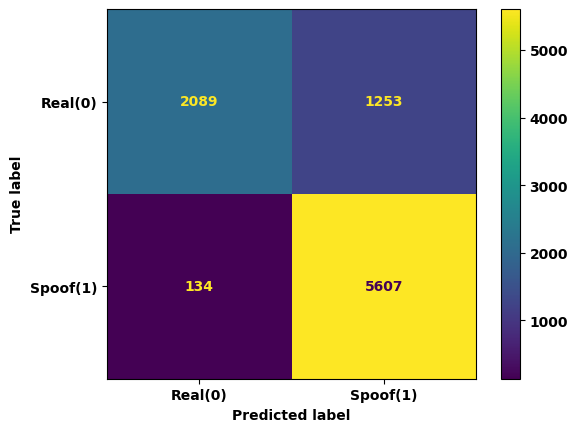

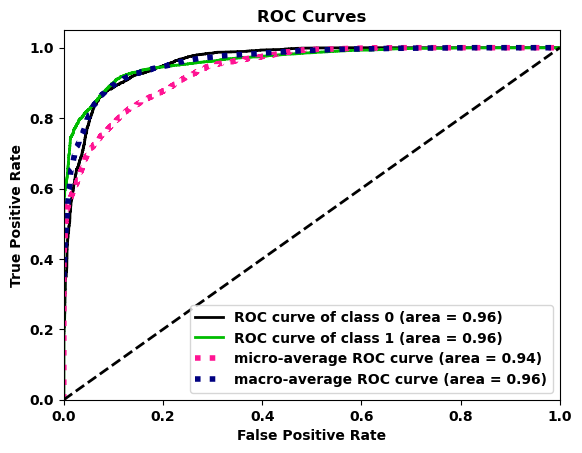

In [61]:
# Calculation and display of various metrics and curves

accu = metrics.accuracy_score(labelss, predictions)
conf_met = metrics.confusion_matrix(y_true=labelss, y_pred=predictions, labels=[0, 1])
tp, fn, fp, tn = conf_met.ravel()

disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_met, display_labels=['Real(0)', 'Spoof(1)'])
disp.plot();
disp.figure_.savefig('face_anti_spoofing_model' +'roc.png', format='PNG')

plot = skplt.metrics.plot_roc(labelss, pred_prob)
fig = plot.get_figure()
fig.savefig('face_anti_spoofing_model' +'Cmat.png', format='PNG')

APCER, BPCER, ACER = calc_metrices(tp, tn, fp, fn)
print(f"Accuracy ->  {accu*100}")
print(f'True Positive -> {tp}   True Negative -> {tn}')
print(f'False Positive -> {fp}   False Negative -> {fn}')
print(f"APCER -> {APCER},  BPCER -> {BPCER},  ACER -> {ACER}")

# current_time = datetime.datetime.now()
# print("execution date and time:", current_time)